In [1]:
import rasterio
from rasterio.windows import from_bounds

def crop_isis_cube_to_crism(isis_cube_path, crism_bounds, output_path):
    """
    Crops a ISIS cube (works both for CTX and CaSSIS) to a rectangle covering a CRISM image.

    Parameters:
    - isis_cube_path: str, path to the ISIS cube file.
    - crism_path: str, path to the CRISM image file.
    - output_path: str, path to save the cropped ISIS cube.
    - buffer: float, additional buffer in map units (e.g., meters).

    Returns:
    - None
    """
    
    with rasterio.open(isis_cube_path, driver="ISIS3") as isis_ds:
        # Calculate the crop window for the ISIS cube
        crop_window = from_bounds(*crism_bounds, transform=isis_ds.transform)
        
        # Read and save the cropped ISIS cube
        cropped_data = isis_ds.read(window=crop_window)
        cropped_transform = isis_ds.window_transform(crop_window)
        
        profile = isis_ds.profile
        profile.update({
            "width": cropped_data.shape[2],
            "height": cropped_data.shape[1],
            "transform": cropped_transform
        })
        
        with rasterio.open(output_path, "w", **profile) as dst:
            dst.write(cropped_data)

def crop_crism(crism_path, crism_bounds, output_path):

    with rasterio.open(crism_path) as crism_ds:
        crop_window = from_bounds(*crism_bounds, transform=crism_ds.transform)

        cropped_data = crism_ds.read(window=crop_window)
        cropped_transform = crism_ds.window_transform(crop_window)

        meta = crism_ds.profile
        meta.update({
            "width": cropped_data.shape[2],
            "height": cropped_data.shape[1],
            "transform": cropped_transform
        })

        with rasterio.open(output_path, "w", **meta) as dst:
            dst.write(cropped_data)


### Bound test

CRISM Bounds: BoundingBox(left=-17854.819107942, bottom=1011599.2322554903, right=17954.690687787268, top=1081575.9192006)
CRISM CRS: PROJCS["Sinusoidal_Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396190,0]],PRIMEM["Reference_Meridian",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",77.231988118807],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


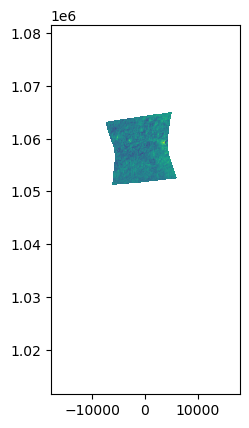

In [13]:
import rasterio
from rasterio.plot import show

with rasterio.open('./evcs/reprojected/processed/FRT0001642E_07_IFEVCJ_MTR3.rp.img') as crism_ds:
    print("CRISM Bounds:", crism_ds.bounds)
    print("CRISM CRS:", crism_ds.crs)
    show(crism_ds)  # Visualize to confirm extent


### Batch processing

In [ ]:
import os
from utils import jezero_crater_pairs, jezero_crism_cassis_pairs, calculate_valid_bounds, get_base_name

def batch_crop_to_valid(
    evc_dir,
    isis_cubes_dir,
    isis_cubes_output_dir,
    evc_output_dir,
    pairs_dict,
    bounds_fn,
    crop_isis_fn,
    crop_crism_fn,
    evc_ext=".tif",
    isis_cubes_ext=".cub",
    filename_builder=None,
):

    os.makedirs(isis_cubes_output_dir, exist_ok=True)
    os.makedirs(evc_output_dir, exist_ok=True)

    isis_cubes_files = [f for f in os.listdir(isis_cubes_dir) if f.endswith(isis_cubes_ext)]

    for file in os.listdir(evc_dir):
        if not file.endswith(evc_ext):
            continue
        try:
            evc_base_name = get_base_name(file)
            isis_cube_base_name = pairs_dict[evc_base_name]

            # Find ISIS cube file whose base name contains isis_cube_base_name
            isis_cube_file = None
            for candidate in isis_cubes_files:
                if isis_cube_base_name in get_base_name(candidate):
                    isis_cube_file = candidate
                    break
            if isis_cube_file is None:
                raise FileNotFoundError(f"No CaSSIS file found for {isis_cube_base_name}")

            if filename_builder is None:
                isis_cube_output_name = f"{evc_base_name}_{isis_cube_base_name}{isis_cubes_ext}"
            else:
                isis_cube_output_name = filename_builder(evc_base_name, isis_cube_base_name, isis_cubes_ext)

            evc_path = os.path.join(evc_dir, file)
            isis_cube_path = os.path.join(isis_cubes_dir, isis_cube_file)
            isis_cube_output_path = os.path.join(isis_cubes_output_dir, isis_cube_output_name)
            evc_output_path = os.path.join(evc_output_dir, file)

            crism_bounds = bounds_fn(evc_path)
            crop_isis_fn(isis_cube_path, crism_bounds, isis_cube_output_path)
            crop_crism_fn(evc_path, crism_bounds, evc_output_path)

            print(f"Finished: {file}")
        except Exception as e:
            print(f"Error processing {file}: {e}")


# Example usage (adjust paths)
batch_crop_to_valid(
    evc_dir = "",
    evc_output_dir = "",
    isis_cubes_dir = "",
    isis_cubes_output_dir = "",
    pairs_dict = jezero_crism_cassis_pairs, # or jezero_crater_pairs for CTX-CRISM pairs
    bounds_fn = calculate_valid_bounds,
    crop_isis_fn = crop_isis_cube_to_crism,
    crop_crism_fn = crop_crism,
)


Finished: FRT00005C5E_07_IFEVCJ_MTR3.tif
